# ***Notes:***

### ***Facebook Prophet Library:***
* [Facebook/Meta Prophet Docs](https://facebook.github.io/prophet/docs/quick_start)
* [What is FB Prophet?](https://towardsdatascience.com/time-series-analysis-with-facebook-prophet-how-it-works-and-how-to-use-it-f15ecf2c0e3a)
* FB Prophet plot explanations w/ examples:
  * [Example 1 - TDS](https://towardsdatascience.com/facebook-prophet-for-time-series-forecasting-in-python-part1-d9739cc79b1d)
  * [Example 2 - Blog](https://www.mikulskibartosz.name/prophet-plot-explained/)

### ***To-Do:***
* *(01/24/2022):*
  * Add block to remove outliers and see what happens to forecast(s)
  * Brainstorm additional regressors to add (if any)
  * Write script to automatically update at routine interval (i.e. daily)

### ***About:***
**Author**: Jordan Eisinger, Data Scientist \
**Created On**: 01/01/2023 \
**Last Updated On**: 03/16/2023

# ***Install & Import Libraries***
___

In [1]:
pip install prophet


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install psycopg2


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import pandas.io.sql as sqlio # Reads SQL query or database atable in a DataFrame
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import date, datetime
from prophet import Prophet
import json
import psycopg2
import itertools
from IPython.display import display, Markdown

Importing plotly failed. Interactive plots will not work.


# ***Setup & Test Database Connection***
___

In [4]:
# Opens AWS credentials stored in JSON object
with open('.creds.json',"r") as f:
    # Assigns dictionary varibale for credentials as JSON object
    creds = json.loads(f.read())
    
# Define connection object
# '**' passes arguments in the entire dictionary
conn = psycopg2.connect(**creds)

# Create cursor object
# Needed to execute PostgresSQL commands
try:
    with conn.cursor() as curs:
        # Test String query
        query = 'SELECT * FROM seeking_arrange.profiles WHERE id = 34601598 LIMIT 5'
        # Execute query
        curs.execute(query)
        # Print results
        for record in curs:
            print(record)
finally:
    # Closes connection
    conn.close()

FileNotFoundError: [Errno 2] No such file or directory: '.creds.json'

# ***Declare Functions***
___

In [5]:
# Opens AWS credentials stored in JSON object
with open('.creds.json',"r") as f:
    # Assigns dictionary varibale for credentials as JSON object
    creds = json.loads(f.read())

# Fucntion to execute SQl queries
def execute_rs_query_to_df(query=str,data=None):
    '''
    Establish database connection, execute SQL query and write output into a Pandas DataFrame.
            Parameters:
                    query (str): A string for the SQL query to be executed
                    data (None): Parameters to pass (None)
    '''
    try:
        # Define database connection object and pass entire dictionary
        conn = psycopg2.connect(**creds)
        # Execute SQL query into a DataFrame
        return sqlio.read_sql_query(query,conn,params=data)
    finally:
        # Close connection
        conn.close()

FileNotFoundError: [Errno 2] No such file or directory: '.creds.json'

In [6]:
# Define function to clean dataframe
def clean_data(d):
    '''
    Clean Pandas DataFrame: Drop first and last row, remove timestamp.
            Parameters:
                    d (Any): A Pandas DataFrame
            Returns:        
                    d (DataFrame): A Pandas DataFrame formatted correctly for FB Prophet model
    '''
    # Drop first row
    d = d.drop(0)
    # Drop last row
    d = d.drop(max(d.index))
    # Remove timestamp from first column
    d['ds'] = pd.to_datetime(d['ds'].dt.date)
    # Return DataFrame in correct format
    return d

In [7]:
# Define function to calculate number of days to forecast
def get_forecasting_period(beg=str,end=str):
    '''
    Return the number of days to forecast into the future based on input dates.
            Parameters:
                    beg (str): A string for the beginning of the forecast period
                    end (str): A string for the end of the forecast period
            Returns:
                    days (int): Integer of days to forecast into the future
    '''
    # Import datetime package
    import datetime

    # Converts date into correct format
    d1 = datetime.datetime.strptime(beg,"%Y/%m/%d")
    d2 = datetime.datetime.strptime(end,"%Y/%m/%d")

    # Calculates the number of days to forecast
    days = (d2 - d1).days
    
    # Return number of days to forecast as an integer 
    return days

# ***All Seeking Forecasts***
___

## **Define Forecasting Period**

In [16]:
# Define forecast start and end dates
start_date = date.today().strftime("%Y/%m/%d") # Current day
end_date = '2025/01/01'

# Call function and assign output to variable
period = get_forecasting_period(start_date,end_date)
period

211

## **Only Net Revenue**

In [7]:
# Net revenue query
net_rev_query = '''
-- Get rid of test processor payments
WITH u2p_test_processor_payments_dt AS (
  SELECT DISTINCT payment_id
  FROM u2p_sites.response_data
  WHERE 1=1
    AND response_data LIKE '%Test Processor%'
)
-- Net Revenue
SELECT
    DATE_TRUNC('day', pl.created_at AT TIME ZONE 'america/los_angeles') AS ds,
    SUM(pl.amount_usd) AS y
FROM u2p_sites.paymentlogs AS pl
INNER JOIN u2p_sites.payments AS p ON p.id = pl.payment_id
LEFT JOIN u2p_test_processor_payments_dt AS t ON t.payment_id = p.id
WHERE 1=1
    AND pl.created_at >= '2018-01-01'
    --> Only Seeking
    AND p.site_id IN (1)
    AND t.payment_id IS NULL
GROUP BY 1
ORDER BY 1
'''

In [96]:
# Call function to execute SQL query
# df = execute_rs_query_to_df(net_rev_query)
# df = pd.read_csv('/Users/jordaneisinger/forecasting/data/sql_runner_jh79rp5zc6gf4q_2024-05-14_17-25-34.csv')
df = pd.read_csv('/Users/jordaneisinger/forecasting/data/rev_2024-06-05_04.csv')

# df = df.reset_index(drop=True)

# Call function to clean DataFrame
# clean_data(df)
# Drop first row
df = df.drop(0)
# Drop last row
df = df.drop(max(df.index))
# Remove timestamp from first column
# Convert the 'ds' column to datetime format, handling errors
df['ds'] = pd.to_datetime(df['ds'], errors='coerce')

df.head()

ds          y
1 2018-01-01  139151.56
2 2018-01-02  166398.82
3 2018-01-03  151877.83
4 2018-01-04  147666.34
5 2018-01-05  126027.97

In [101]:
join_df = pd.read_csv('/Users/jordaneisinger/forecasting/data/joins_2024-06-05.csv')

# Rename columns
join_df.rename(columns={'profiles.created_date': 'ds'}, inplace=True)
join_df.rename(columns={'profiles.count': 'joins'}, inplace=True)

# Sort DataFrame based on the first column 'A' in ascending order
join_df = join_df.sort_values(by='ds', ascending=True)
join_df = join_df.reset_index(drop=True)
# Adjust the index to start at 1
join_df.index = join_df.index + 1

# Drop last row
join_df = join_df.drop(max(join_df.index))
# Convert the 'ds' column to datetime format, handling errors
join_df['ds'] = pd.to_datetime(join_df['ds'], errors='coerce')

join_df.head()

ds  joins
1 2018-01-01  13404
2 2018-01-02  17631
3 2018-01-03  18894
4 2018-01-04  18056
5 2018-01-05  14663

In [102]:
# Concatenate DataFrames horizontally (side by side)
final_df = pd.concat([df, join_df['joins']], axis=1)
final_df.tail()

ds          y  joins
2342 2024-05-30  190158.72   5809
2343 2024-05-31  234668.86   5394
2344 2024-06-01  227807.97   5002
2345 2024-06-02  220946.78   5560
2346 2024-06-03  237666.45   6040

In [98]:
# Instantiate Prophet object
model = Prophet()

# Call fit method
model.fit(df)
# --> The above sometimes returns an error, here is a possible reason why: https://stackoverflow.com/questions/73255165/library-not-loaded-rpath-libtbb-dylib-in-prophet-python
# --> Error seems to have been fixed usng method described here: https://github.com/facebook/prophet/issues/2250

# Create new dataframe that extends into the future a set number of days
future = model.make_future_dataframe(periods=period)

# Use predict method for future dates
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

22:55:14 - cmdstanpy - INFO - Chain [1] start processing
22:55:15 - cmdstanpy - INFO - Chain [1] done processing


ds           yhat     yhat_lower     yhat_upper
2552 2024-12-27  227985.427785  208972.367201  248318.668786
2553 2024-12-28  223211.958170  202786.766829  242056.701849
2554 2024-12-29  230123.997241  210629.566997  249134.958791
2555 2024-12-30  239851.855322  220063.072203  258919.438421
2556 2024-12-31  231438.052692  212739.837569  250893.997932

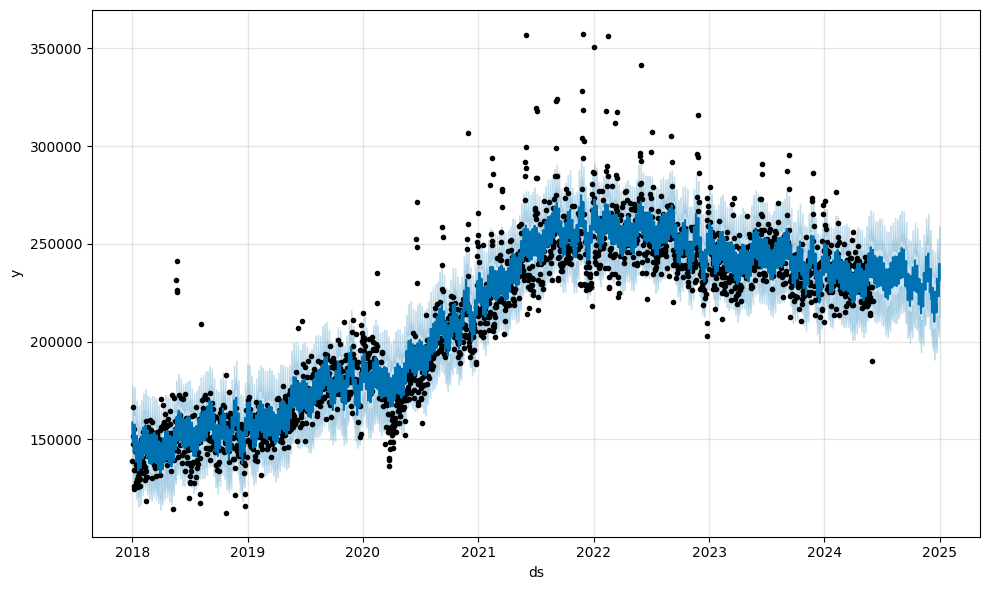

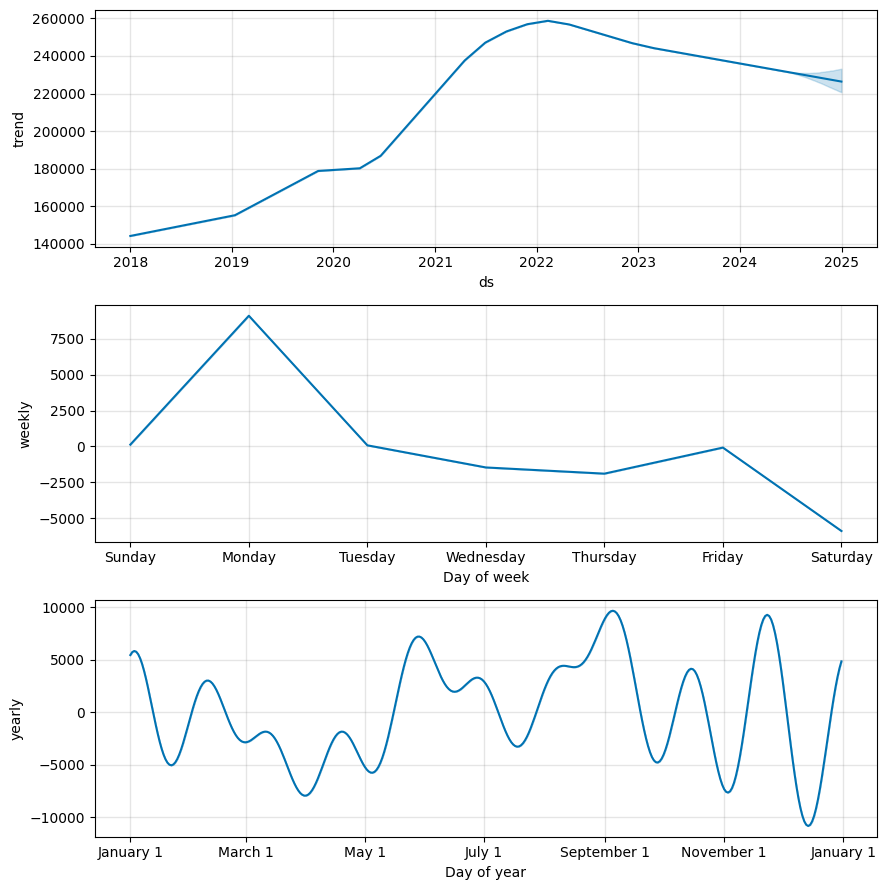

In [99]:
# Plot
fig1 = model.plot(forecast)
fig2 = model.plot_components(forecast)

In [100]:
# 2024 prediction ranges
print("LOWER (NET):", sum(forecast[forecast.ds > '2023-12-31'].yhat_lower))
print("MIDDLE (NET):", sum(forecast[forecast.ds > '2023-12-31'].yhat))
print("UPPER (NET):", sum(forecast[forecast.ds > '2023-12-31'].yhat_upper))

LOWER (NET): 77805672.21023752
MIDDLE (NET): 84624557.64265245
UPPER (NET): 91481886.83620201


In [103]:
# Initialize the Prophet model for 'joins'
joins_model = Prophet()
joins_model.fit(join_df[['ds', 'joins']].rename(columns={'joins': 'y'}))

# Create a DataFrame for future 'joins' predictions
future_joins = joins_model.make_future_dataframe(periods=period)
joins_forecast = joins_model.predict(future_joins)

# Extract the forecasted 'joins' values
future_joins['joins'] = joins_forecast['yhat']

22:56:31 - cmdstanpy - INFO - Chain [1] start processing
22:56:31 - cmdstanpy - INFO - Chain [1] done processing


In [123]:
# Initialize the Prophet model for 'y'
y_model = Prophet()
y_model.add_regressor('joins')

# Fit the model for 'y'
y_model.fit(final_df)

# Create a DataFrame for future 'y' predictions
future = y_model.make_future_dataframe(periods=period)
future = future.merge(future_joins[['ds', 'joins']], on='ds', how='left')

# Make predictions for 'y'
y_forecast = y_model.predict(future)

# Print only the necessary columns
y_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

23:04:13 - cmdstanpy - INFO - Chain [1] start processing
23:04:13 - cmdstanpy - INFO - Chain [1] done processing


ds           yhat     yhat_lower     yhat_upper
2552 2024-12-27  228339.488196  207825.699539  246663.536103
2553 2024-12-28  223566.134508  204149.612756  242275.581647
2554 2024-12-29  230478.059820  210955.141778  248774.945016
2555 2024-12-30  240206.256923  222443.067805  259323.703013
2556 2024-12-31  231793.110883  212556.664640  251849.702642

In [124]:
# 2024 prediction ranges
print("LOWER (NET):", sum(y_forecast[y_forecast.ds > '2023-12-31'].yhat_lower))
print("MIDDLE (NET):", sum(y_forecast[y_forecast.ds > '2023-12-31'].yhat))
print("UPPER (NET):", sum(y_forecast[y_forecast.ds > '2023-12-31'].yhat_upper))

LOWER (NET): 77948873.0551619
MIDDLE (NET): 84702598.84573643
UPPER (NET): 91504099.277856


# **Promo Day Binary Variables**

In [98]:
# Add promo day regressor
promos = pd.Series([
    '2020-02-12', '2020-02-13', '2020-02-14', '2020-02-15', 
    '2020-02-16', '2020-03-17', '2020-03-18', '2020-03-19', 
    '2020-03-20', '2020-03-21', '2020-06-18', '2020-06-19', 
    '2020-06-20', '2020-06-21', '2020-06-22', '2020-09-07', 
    '2020-09-08', '2020-09-09', '2020-09-10', '2020-09-11', 
    '2020-09-12', '2020-11-25', '2020-11-26', '2020-11-27', 
    '2020-11-28', '2020-11-29', '2020-11-30', '2020-12-01', 
    '2021-02-08', '2021-02-09', '2021-02-10', '2021-02-11', 
    '2021-02-12', '2021-02-13', '2021-02-14', '2021-02-15', 
    '2021-03-12', '2021-03-13', '2021-03-14', '2021-03-15', 
    '2021-03-16', '2021-03-17', '2021-05-27', '2021-05-28', 
    '2021-05-29', '2021-05-30', '2021-05-31', '2021-06-01', 
    '2021-07-01', '2021-07-02', '2021-07-03', '2021-07-04', 
    '2021-07-05', '2021-07-06', '2021-09-02', '2021-09-03', 
    '2021-09-04', '2021-09-05', '2021-09-06', '2021-09-07', 
    '2021-11-24', '2021-11-25', '2021-11-26', '2021-11-27', 
    '2021-11-28', '2021-11-29', '2021-11-30', '2021-12-23', 
    '2021-12-24', '2021-12-25', '2021-12-26', '2021-12-27', 
    '2021-12-28', '2021-12-29', '2021-12-30', '2021-12-31', 
    '2022-01-01', '2022-01-02', '2022-01-03', '2022-02-08', 
    '2022-02-09', '2022-02-10', '2022-02-11', '2022-02-12', 
    '2022-02-13', '2022-02-14', '2022-02-15', '2022-03-10', 
    '2022-03-11', '2022-03-12', '2022-03-13', '2022-03-14', 
    '2022-03-15', '2022-03-16', '2022-03-17', '2022-05-26', 
    '2022-05-27', '2022-05-28', '2022-05-29', '2022-05-30', 
    '2022-05-31', '2022-06-01', '2022-06-30', '2022-07-01', 
    '2022-07-02', '2022-07-03', '2022-07-04', '2022-07-05', 
    '2022-07-06', '2022-09-01', '2022-09-02', '2022-09-03', 
    '2022-09-04', '2022-09-05', '2022-09-06', '2022-09-07', 
    '2022-11-23', '2022-11-24', '2022-11-25', '2022-11-26', 
    '2022-11-27', '2022-11-28', '2022-11-29', '2023-01-01',
    '2023-01-02', '2023-01-03', '2023-02-08', '2023-02-09', 
    '2023-02-10', '2023-02-11', '2023-02-12', 
    '2023-02-13', '2023-02-14', '2023-02-15', '2023-03-10', 
    '2023-03-11', '2023-03-12', '2023-03-13', '2023-03-14', 
    '2023-03-15', '2023-03-16', '2023-03-17', '2023-05-26', 
    '2023-05-27', '2023-05-28', '2023-05-29', '2023-05-30', 
    '2023-05-31', '2023-06-01', '2023-06-30', '2023-07-01', 
    '2023-07-02', '2023-07-03', '2023-07-04', '2023-07-05', 
    '2023-07-06', '2023-09-01', '2023-09-02', '2023-09-03', 
    '2023-09-04', '2023-09-05', '2023-09-06', '2023-09-07', 
    '2023-11-23', '2023-11-24', '2023-11-25', '2023-11-26', 
    '2023-11-27', '2023-11-28', '2023-11-29'
])
thirty_days_after_promos = pd.Series([
    '2020-03-13', '2020-03-14', '2020-03-15', '2020-03-16',
    '2020-03-17', '2020-04-16', '2020-04-17', '2020-04-18',
    '2020-04-19', '2020-04-20', '2020-07-18', '2020-07-19',
    '2020-07-20', '2020-07-21', '2020-07-22', '2020-10-07',
    '2020-10-08', '2020-10-09', '2020-10-10', '2020-10-11',
    '2020-10-12', '2020-12-25', '2020-12-26', '2020-12-27',
    '2020-12-28', '2020-12-29', '2020-12-30', '2020-12-31',
    '2021-03-10', '2021-03-11', '2021-03-12', '2021-03-13',
    '2021-03-14', '2021-03-15', '2021-03-16', '2021-03-17',
    '2021-04-11', '2021-04-12', '2021-04-13', '2021-04-14',
    '2021-04-15', '2021-04-16', '2021-06-26', '2021-06-27',
    '2021-06-28', '2021-06-29', '2021-06-30', '2021-07-01',
    '2021-07-31', '2021-08-01', '2021-08-02', '2021-08-03',
    '2021-08-04', '2021-08-05', '2021-10-02', '2021-10-03',
    '2021-10-04', '2021-10-05', '2021-10-06', '2021-10-07',
    '2021-12-24', '2021-12-25', '2021-12-26', '2021-12-27',
    '2021-12-28', '2021-12-29', '2021-12-30', '2022-01-22',
    '2022-01-23', '2022-01-24', '2022-01-25', '2022-01-26',
    '2022-01-27', '2022-01-28', '2022-01-29', '2022-01-30',
    '2022-01-31', '2022-02-01', '2022-02-02', '2022-03-10',
    '2022-03-11', '2022-03-12', '2022-03-13', '2022-03-14',
    '2022-03-15', '2022-03-16', '2022-03-17', '2022-04-09',
    '2022-04-10', '2022-04-11', '2022-04-12', '2022-04-13',
    '2022-04-14', '2022-04-15', '2022-04-16', '2022-06-25',
    '2022-06-26', '2022-06-27', '2022-06-28', '2022-06-29',
    '2022-06-30', '2022-07-01', '2022-07-30', '2022-07-31',
    '2022-08-01', '2022-08-02', '2022-08-03', '2022-08-04',
    '2022-08-05', '2022-10-01', '2022-10-02', '2022-10-03',
    '2022-10-04', '2022-10-05', '2022-10-06', '2022-10-07',
    '2022-12-23', '2022-12-24', '2022-12-25', '2022-12-26',
    '2022-12-27', '2022-12-28', '2022-12-29', '2023-01-22',
    '2023-01-23', '2023-01-24', '2023-01-25', '2023-01-26',
    '2023-01-27', '2023-01-28', '2023-01-29', '2023-01-30',
    '2023-01-31', '2023-02-01', '2023-02-02', '2023-03-10',
    '2023-03-11', '2023-03-12', '2023-03-13', '2023-03-14',
    '2023-03-15', '2023-03-16', '2023-03-17', '2023-04-09',
    '2023-04-10', '2023-04-11', '2023-04-12', '2023-04-13',
    '2023-04-14', '2023-04-15', '2023-04-16', '2023-06-25',
    '2023-06-26', '2023-06-27', '2023-06-28', '2023-06-29',
    '2023-06-30', '2023-07-01', '2023-07-30', '2023-07-31',
    '2023-08-01', '2023-08-02', '2023-08-03', '2023-08-04',
    '2023-08-05', '2023-10-01', '2023-10-02', '2023-10-03',
    '2023-10-04', '2023-10-05', '2023-10-06', '2023-10-07',
    '2023-12-23', '2023-12-24', '2023-12-25', '2023-12-26',
    '2023-12-27', '2023-12-28', '2023-12-29'
])

In [100]:
# Call function to execute SQL query
df = execute_rs_query_to_df(net_rev_query)

# Call function to clean DataFrame
clean_data(df)

# Create dummy variable for promo days and 30 days after promo days
df['promo'] = np.where(pd.to_datetime(df['ds']).isin(promos),1,0)
df['thirty_days_after_promo'] = np.where(pd.to_datetime(df['ds']).isin(thirty_days_after_promos),1,0)

/var/folders/dc/rhdj5x955qb0m2r34vvqdlg40000gq/T/ipykernel_48101/748776041.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return sqlio.read_sql_query(query,conn,params=data)


In [109]:
# Instantiate Prophet object 
model = Prophet()

# Add promo regressor
model.add_regressor('promo')

# Call fit method
model.fit(df)

# Create new dataframe that extends into the future set number of periods
future = model.make_future_dataframe(periods=period)

# Add new regressor fields
future['promo'] = np.where(pd.to_datetime(future['ds']).isin(promos),1,0)
# future['thirty_days_after_promo'] = np.where(pd.to_datetime(future['ds']).isin(thirty_days_after_promos),1,0)

# Use predict method for dates in the future
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

16:18:57 - cmdstanpy - INFO - Chain [1] start processing
16:18:57 - cmdstanpy - INFO - Chain [1] done processing


ds           yhat     yhat_lower     yhat_upper
2187 2023-12-27  226515.740160  201435.396645  252015.079201
2188 2023-12-28  225378.757388  197513.724684  252991.495139
2189 2023-12-29  227431.510544  202014.030456  253685.139560
2190 2023-12-30  221633.817153  196940.173128  249227.269608
2191 2023-12-31  229015.682895  202541.964265  255252.834958

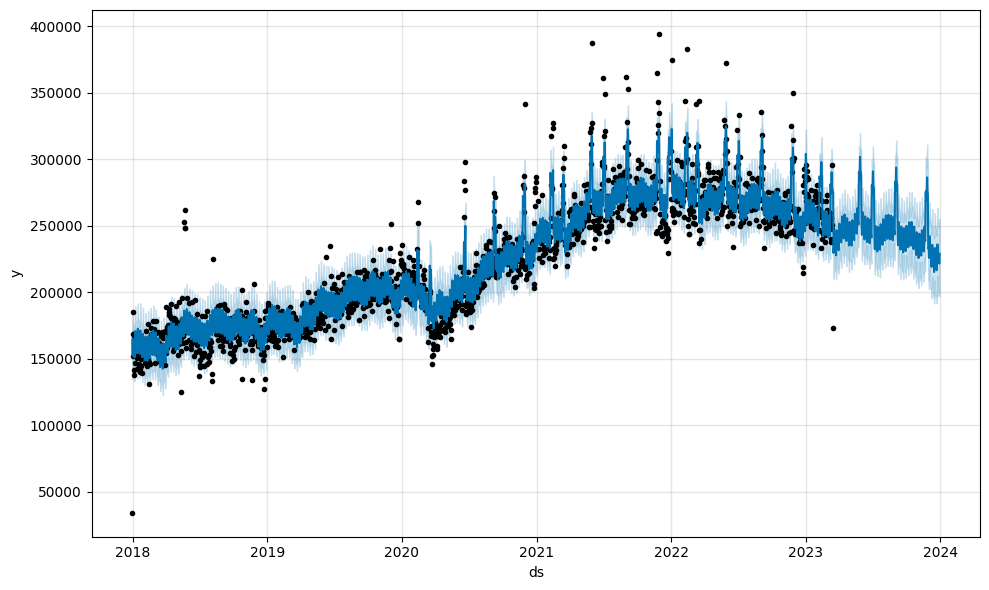

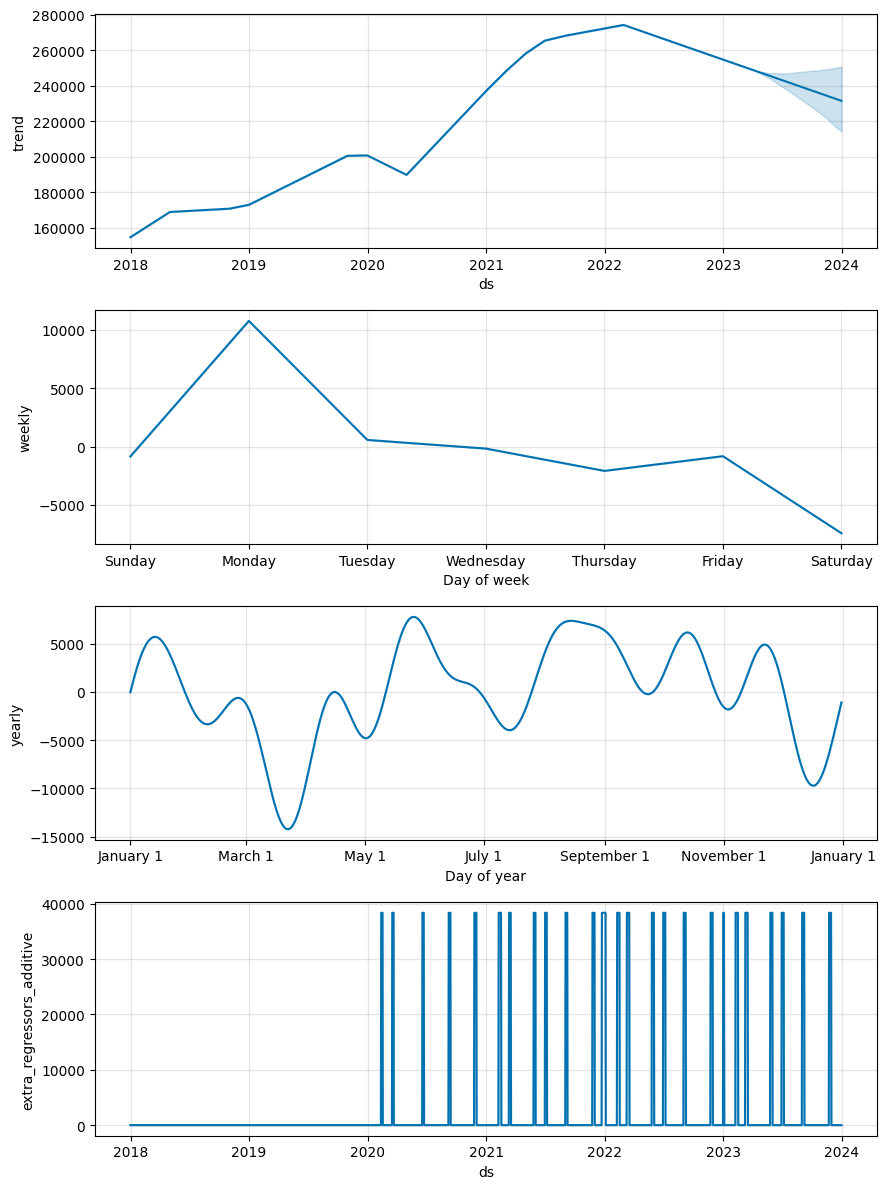

In [110]:
# Plot
fig1 = model.plot(forecast)
fig2 = model.plot_components(forecast)

In [111]:
# 2023 prediction ranges
print("LOWER:", sum(forecast[forecast.ds > '2022-12-31'].yhat_lower))
print("MIDDLE:", sum(forecast[forecast.ds > '2022-12-31'].yhat))
print("UPPER:", sum(forecast[forecast.ds > '2022-12-31'].yhat_upper))

LOWER: 83231663.31721705
MIDDLE: 90490298.8917978
UPPER: 97906273.67893368
